In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import os
import glob
import wave
import core as co
import pydub
import librosa
import itertools
import numpy as np
import contextlib
import tensorflow as tf
import sklearn.metrics as metrics

In [2]:
####https://github.com/aqibsaeed/Urban-Sound-Classification/blob/master/Urban%20Sound%20Classification%20using%20CNN.ipynb
####https://aqibsaeed.github.io/2016-09-03-urban-sound-classification-part-1/

In [3]:
paths = ['BD15C', 'BD6B', 'BD6A', 'BD15A'] # 'BD15L'

In [4]:
def windows(data, window_size):
    start = 0
    while start < len(data):
        yield start, start + window_size
        start += (window_size / 2)


def extract_features(parent_dir,sub_dirs,file_ext="*.wav",bands = 60, frames = 41, label = 1):
    window_size = 512 * (frames - 1)
    log_specgrams = []
    labels = []
    for l, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            sound_clip,s = librosa.load(fn)
            for (start,end) in windows(sound_clip,window_size):
                if(len(sound_clip[start:end]) == window_size):
                    signal = sound_clip[start:end]
                    melspec = librosa.feature.melspectrogram(signal, n_mels = bands)
                    logspec = librosa.logamplitude(melspec)
#                     logspec = logspec.T.flatten()[:, np.newaxis].T
                    log_specgrams.append(logspec)
                    labels.append(l)
            
    log_specgrams = np.asarray(log_specgrams).reshape(len(log_specgrams),bands,frames,1)
    features = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams))), axis = 3)
    for i in range(len(features)):
        features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
    
    return np.array(features), np.array(labels)

In [5]:
parent_dir = '.'

if os.path.exists('train_features.npy') and os.path.exists('train_labels.npy'):
    train_features = np.load('train_features.npy')
    train_labels = np.load('train_labels.npy')
else:
    train_features,train_labels = extract_features(parent_dir,paths,frames=41)
    train_labels = co.one_hot_encode(train_labels)
    np.save('train_features.npy', train_features)
    np.save('train_labels.npy', train_labels)

In [6]:
if os.path.exists('test_features.npy') and os.path.exists('test_labels.npy'):
    test_features = np.load('test_features.npy')
    test_labels = np.load('test_labels.npy')
else:
    test_features = None
    test_labels = []
    for l, path in enumerate(paths):
        subdir = os.path.join(parent_dir, path)
        f,_ = extract_features(path,['test'],frames=41)
        test_features = f if test_features is None else np.append(test_features, f, axis=0)
        a = [l] * f.shape[0]
        test_labels.append(a)
    test_labels = co.one_hot_encode(list(itertools.chain(*test_labels)))
    np.save('test_features.npy', test_features)
    np.save('test_labels.npy', test_labels)

In [7]:
train_x = train_features
train_y = train_labels
test_x = test_features
test_y = test_labels

In [8]:
print train_x.shape
print train_y.shape
print test_x.shape
print test_y.shape

(774, 60, 41, 2)
(774, 4)
(130, 60, 41, 2)
(130, 4)


In [9]:
frames = 41
bands = 60

num_labels = 4
num_channels = 2

batch_size = 50
kernel_size = 30
depth = 32
num_hidden = 200

starter_learning_rate = 1e-5
training_iterations = 4000
step = 300
decay = 0.75

In [10]:
X = tf.placeholder(tf.float32, shape=[None, bands, frames, num_channels])
Y = tf.placeholder(tf.float32, shape=[None, num_labels])
phase_train = tf.placeholder(tf.bool, name='phase_train')
global_step = tf.Variable(0, trainable=False)

conv1 = co.conv_layer(X, num_channels, depth, phase_train, 'conv1', kernel_size, kernel_size)
conv2 = co.conv_layer(conv1, depth, depth*2, phase_train, 'conv2', kernel_size, kernel_size)
max_pool_1 = co.max_pool_layer(conv2, name='max_pool_1')
shape = max_pool_1.get_shape().as_list()
max_pool_1_flat = tf.reshape(max_pool_1, [-1, shape[1] * shape[2] * shape[3]])

fc1 = co.fc_layer(max_pool_1_flat, shape[1] * shape[2] * shape[3], num_hidden, phase_train, 'fc1') # fc_layer fc1
y_ = co.fc_layer(tf.nn.relu(fc1), num_hidden, num_labels, phase_train, 'fc2')

In [11]:
learning_rate = tf.train.exponential_decay(starter_learning_rate,global_step,step,decay,staircase=True)

with tf.name_scope('xent'):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=y_))
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy, global_step=global_step)
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [12]:
cost_history = np.empty(shape=[1],dtype=float)
with tf.Session() as session:
    session.run(tf.global_variables_initializer())

    for itr in range(training_iterations):    
        offset = (itr * batch_size) % (train_y.shape[0] - batch_size)
        batch_x = train_x[offset:(offset + batch_size), :, :, :]
        batch_y = train_y[offset:(offset + batch_size), :]
        
        _, c, a = session.run([optimizer, cross_entropy, accuracy],feed_dict={X: batch_x, Y : batch_y, phase_train : True})
        cost_history = np.append(cost_history,c)
        if itr % 50 == 0:
            _, tc, ta = session.run([optimizer, cross_entropy, accuracy],feed_dict={X: test_x, Y : test_y, phase_train : False})
            print ('Train cost', c, 'Accuracy', a, 'Test cost', tc, 'Accuracy', ta)

    y_pred = session.run(y_, feed_dict={X: test_x, Y: test_y, phase_train: False})
    print('Test accuracy',round(session.run(accuracy, feed_dict={X: test_x, Y: test_y, phase_train: False}) , 3))
    

('Train cost', 2.0109541, 'Accuracy', 0.0, 'Test cost', 3.1406016, 'Accuracy', 0.41538462)
('Train cost', 0.47446662, 'Accuracy', 1.0, 'Test cost', 2.7343104, 'Accuracy', 0.11538462)
('Train cost', 1.4068824, 'Accuracy', 0.19999999, 'Test cost', 2.8085179, 'Accuracy', 0.1)
('Train cost', 0.42220372, 'Accuracy', 0.98000002, 'Test cost', 2.8569844, 'Accuracy', 0.16923077)
('Train cost', 0.15039933, 'Accuracy', 1.0, 'Test cost', 2.9226115, 'Accuracy', 0.18461539)
('Train cost', 0.17147836, 'Accuracy', 1.0, 'Test cost', 2.3701944, 'Accuracy', 0.2)
('Train cost', 0.0087991599, 'Accuracy', 1.0, 'Test cost', 3.4074042, 'Accuracy', 0.31538463)
('Train cost', 0.19124682, 'Accuracy', 0.98000002, 'Test cost', 2.0501647, 'Accuracy', 0.1923077)
('Train cost', 0.017576519, 'Accuracy', 1.0, 'Test cost', 2.6256807, 'Accuracy', 0.40000001)
('Train cost', 0.02321863, 'Accuracy', 1.0, 'Test cost', 1.9232394, 'Accuracy', 0.2)
('Train cost', 0.015711702, 'Accuracy', 1.0, 'Test cost', 2.5535917, 'Accuracy',

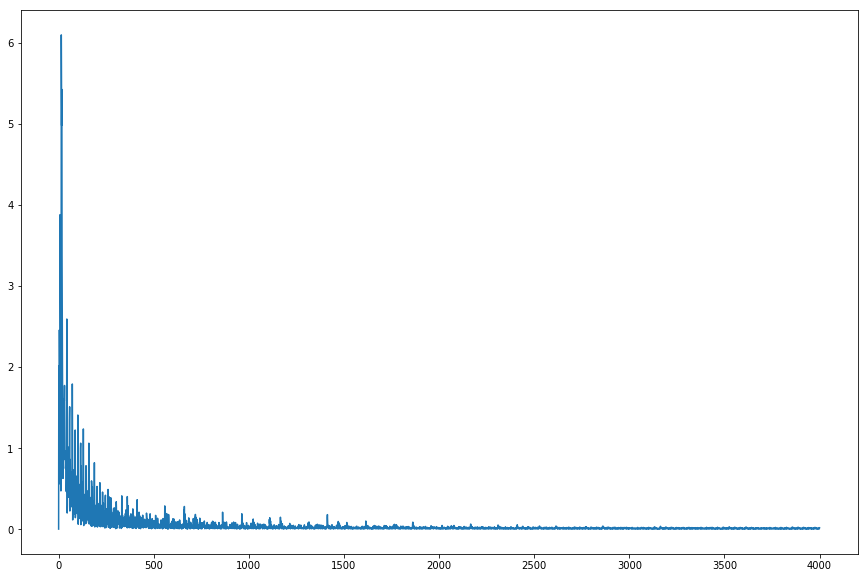

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,10))
plt.plot(cost_history)
# plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

In [14]:
y_test_class = np.argmax(test_y, axis=1)
y_pred_class = np.argmax(y_pred, axis=1)
conf_mat = metrics.confusion_matrix(y_test_class, y_pred_class)

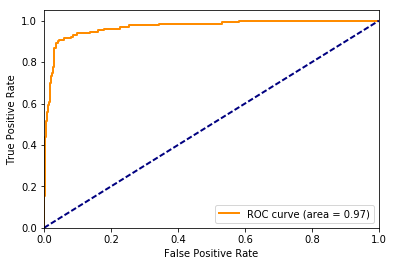

ROC AUC Score:  0.94517307809


In [15]:
# Compute ROC curve and ROC area for each class
n_classes = 4
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(test_y[:, i], y_pred[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(test_y.ravel(), y_pred.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc["micro"])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

roc_score = metrics.roc_auc_score(test_y, y_pred)

#print "Loss: {} Accuracy: {}%".format(loss_and_metrics[0],loss_and_metrics[1] * 100)
print "ROC AUC Score: ", roc_score

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[52  0  2  0]
 [ 2 39  0  0]
 [ 1  0 13  0]
 [ 0  0  0 21]]


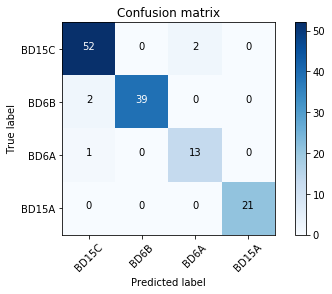

In [17]:
plot_confusion_matrix(conf_mat, classes=paths)